In [1]:
import os
import tensorflow as tf
import gc

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

tf.keras.backend.clear_session()
gc.collect()

0

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
if tf.config.list_physical_devices('GPU'):
  device = 'GPU'
else:
  device = 'CPU'    

print(f"Using {device}")

Using GPU


In [4]:
images = r"/kaggle/input/quake-city-spall-images/image"
masks = r"/kaggle/input/spall-segmented-masks/spall"
train_csv = r"/kaggle/input/excel-train-file/train.csv"
test_csv = r"/kaggle/input/excel-test-files/test.csv"

In [5]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

train_list = train_df.iloc[:, 0].tolist()
test_list = test_df.iloc[:, 0].tolist()

train_image_paths = [os.path.join(images, f) for f in train_list]
train_mask_paths = [os.path.join(masks, f) for f in train_list]

test_image_paths = [os.path.join(images, f) for f in test_list]
test_mask_paths = [os.path.join(masks, f) for f in test_list]

In [6]:
IMG_HEIGHT = 576
IMG_WIDTH = 1024
BATCH_SIZE = 4

AUTOTUNE = tf.data.AUTOTUNE

IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], shape = [1, 1, 3], dtype = tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], shape = [1, 1, 3], dtype = tf.float32)

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.1),
])

def load_image_mask(img_path, mask_path):

  image = tf.io.read_file(img_path)
  image = tf.image.decode_png(image, channels = 3)
  image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
  image = tf.cast(image, tf.float32)/255.0
  image = (image - IMAGENET_MEAN)/IMAGENET_STD

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels = 1)
  mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH), method = "nearest")
  mask = tf.where(mask > 0, 1, 0)
  mask = tf.cast(mask, tf.float32)

  return image, mask

def augment(image, mask):

  combined = tf.concat([image, mask], axis=-1)
  combined = data_augmentation(combined)
  image, mask = combined[..., :3], combined[..., 3:]

  mask = tf.round(mask)

  return image, mask

In [8]:
train_dataset = (tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
                 .map(load_image_mask, num_parallel_calls = AUTOTUNE)
                 .map(augment, num_parallel_calls = AUTOTUNE)
                 .shuffle(512)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTOTUNE))

In [9]:
validation_dataset = (tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))
                      .map(load_image_mask, num_parallel_calls = AUTOTUNE)
                      .batch(BATCH_SIZE)
                      .prefetch(AUTOTUNE))

In [10]:
train_batches = tf.data.experimental.cardinality(train_dataset)
validation_batches = tf.data.experimental.cardinality(validation_dataset)

print(f"Number of training batches: {train_batches.numpy()}")
print(f"Number of validation batches: {validation_batches.numpy()}")

Number of training batches: 951
Number of validation batches: 251


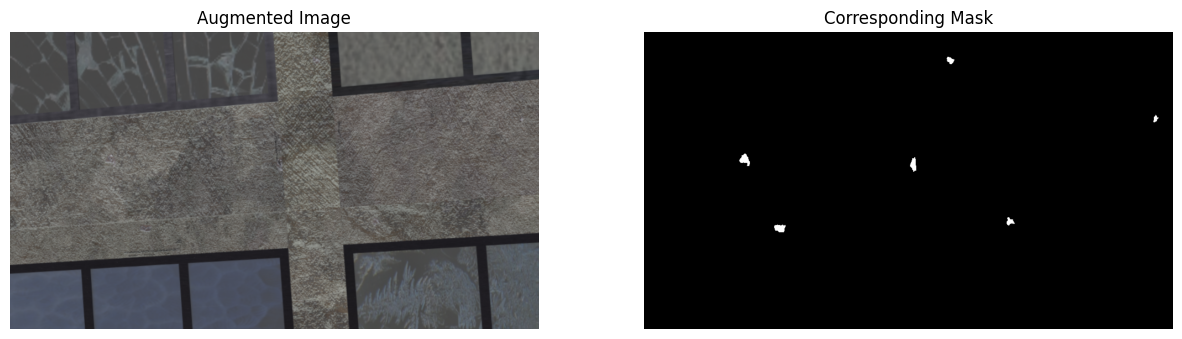

In [13]:
for images, masks in train_dataset.take(1):

  plt.figure(figsize = (15, 5))

  image = images[0]
  mask = masks[0]

  img_disp = (image.numpy()*(IMAGENET_STD.numpy())) + IMAGENET_MEAN.numpy()
  img_disp = np.clip(img_disp, 0, 1)

  plt.subplot(1, 2, 1)
  plt.title("Augmented Image")
  plt.imshow(img_disp)
  plt.axis("off")

  plt.subplot(1, 2, 2)
  plt.title("Corresponding Mask")
  plt.imshow(tf.squeeze(mask), cmap='gray') # Use squeeze to remove the channel dim
  plt.axis("off")

  plt.show()

In [11]:
!pip install tensorflow transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.


In [12]:
from tensorflow.keras import layers, models
from transformers import TFSegformerModel
from tensorflow.keras.layers import Lambda, Concatenate, Reshape, UpSampling2D, Conv2D, Activation, BatchNormalization

AUTOTUNE = tf.data.experimental.AUTOTUNE

INPUT_SIZE = (576, 1024, 3)
BASE_CHANNEL = 16
SEG_PRETRAINED = "nvidia/segformer-b0-finetuned-ade-512-512"

In [13]:
segformer_model = TFSegformerModel.from_pretrained(SEG_PRETRAINED, from_pt = True)
segformer_model.trainable = False

def segformer(inputs, XE5, seg_model):
  def run_segformer(x):
    x = tf.transpose(x, perm = [0, 3, 1, 2])
    out = seg_model(pixel_values = x).last_hidden_state
    return out

  input_height = inputs.shape[1]
  input_width = inputs.shape[2]

  target_height = XE5.shape[1]
  target_width = XE5.shape[2]
  target_channels = XE5.shape[3]

  seg_output_features = Lambda(run_segformer, output_shape = (input_height*input_width//1024, 256))(inputs)
  seg_output_reshaped = Reshape((input_height//32,input_width//32, 256))(seg_output_features)


  seg_output_reshaped = Conv2D(target_channels, 1, padding = "same", kernel_initializer = "he_normal")(seg_output_reshaped) if target_channels != 256 else seg_output_reshaped
  seg_output_upsampled = Lambda(lambda x: tf.image.resize(x, (target_height, target_width), method = "bilinear"))(seg_output_reshaped)

  return seg_output_upsampled
    

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
I0000 00:00:1760851849.079776      37 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1760851850.154845      37 service.cc:148] XLA service 0x3f78f1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760851850.155886      37 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760851850.369484      37 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFSegformerModel: ['decode_head.batch_norm.moving_mean', 'decode_head.batch_norm.moving_variance', 'decode_head.linear_c.0.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.

In [14]:
def encoder_block(input, output_channels, filter_size = 3, dropout = 0, batch_norm = True):

  conv = Conv2D(output_channels, filter_size, padding = "same", kernel_initializer = "he_normal" )(input)
  conv = Activation("relu")(conv)

  conv = Conv2D(output_channels, filter_size, padding = "same", kernel_initializer = "he_normal" )(conv)
  conv = BatchNormalization()(conv) if batch_norm else conv
  conv = Activation("relu")(conv)

  if dropout>0:
    conv = layers.Dropout(dropout)(conv)

  return conv

def decoder_block(input, concat_input, output_channels, filter_size = 3, dropout = 0, batch_norm = True):

  deconv = UpSampling2D(2, interpolation = "bilinear")(input)

  deconv = Conv2D(output_channels, 2, padding = "same", kernel_initializer = "he_normal")(deconv)
  deconv = Concatenate()([deconv, concat_input])
    
  deconv = Conv2D(output_channels, filter_size, padding = "same", kernel_initializer = "he_normal")(deconv)
  deconv = BatchNormalization()(deconv) if batch_norm else deconv
  deconv = Activation("relu")(deconv)
    
  if dropout>0:
    deconv = layers.Dropout(dropout)(deconv)

  return deconv


def attention_block(q, k, v, output_channels, bottleneck = False):

  k = Conv2D(output_channels, 2, strides = 2, padding = "same", kernel_initializer = "he_normal")(k) if not bottleneck else k
  attention = layers.Add()([q, k])
  attention = Activation("relu")(attention)
  attention = Conv2D(1, 1, padding = "same", kernel_initializer = "glorot_uniform")(attention)
  attention = Activation("sigmoid")(attention)
  attention = UpSampling2D(2, interpolation = "bilinear")(attention)
  attention = layers.Multiply()([attention, v])

  return attention


In [15]:
INPUT_SIZE = (576, 1024, 3)
BASE_CHANNEL = 16

In [16]:
def att_unet_with_segformer(input_shape = INPUT_SIZE, base_channel = BASE_CHANNEL):

  inputs = layers.Input(shape = input_shape)

  enc_16 = encoder_block(inputs, base_channel, 3, dropout = 0, batch_norm = True)
  pool_16 = layers.MaxPooling2D((2, 2))(enc_16)

  enc_32 = encoder_block(pool_16, base_channel*2, 3, dropout = 0, batch_norm = True)
  pool_32 = layers.MaxPooling2D((2,2))(enc_32)

  enc_64 = encoder_block(pool_32, base_channel*4, 3, dropout = 0, batch_norm = True)
  pool_64 = layers.MaxPooling2D((2,2))(enc_64)

  enc_128 = encoder_block(pool_64, base_channel*8, 3, dropout = 0, batch_norm = True)
  pool_128 = layers.MaxPooling2D((2,2))(enc_128)

  enc_256 = encoder_block(pool_128, base_channel*16, 3, dropout = 0, batch_norm = True)

  seg_output_256 = segformer(inputs, enc_256, segformer_model)

  attention_dec_128 = attention_block(enc_256, seg_output_256, enc_128, base_channel*16, bottleneck = True)
  dec_128 = decoder_block(enc_256, attention_dec_128, base_channel*8, 3, dropout = 0)

  attention_dec_64 = attention_block(dec_128, enc_64, enc_64, base_channel*8)
  dec_64 = decoder_block(dec_128, attention_dec_64, base_channel*4, 3, dropout = 0)

  attention_dec_32 = attention_block(dec_64, enc_32, enc_32, base_channel*4)
  dec_32 = decoder_block(dec_64, attention_dec_32, base_channel*2, 3, dropout = 0)

  attention_dec_16 = attention_block(dec_32, enc_16, enc_16, base_channel*2)
  dec_16 = decoder_block(dec_32, attention_dec_16, base_channel, 3, dropout = 0)

  out = Conv2D(1, 3, padding = "same", kernel_initializer = "glorot_uniform")(dec_16)
  out = Activation("sigmoid")(out)

  model = models.Model(inputs = inputs, outputs = out, name = "Attention_UNet_with_SegFormer")

  return model

with tf.device(device):
  model = att_unet_with_segformer(input_shape = INPUT_SIZE, base_channel = BASE_CHANNEL)
  model.summary()

Model: "Attention_UNet_with_SegFormer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 576, 1024, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 576, 1024, │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 576, 1024, │          0 │ conv2d[0][0]      │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 576, 1024, │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 576, 1024, │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 576, 1024, │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 288, 512,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 288, 512,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 288, 512,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 288, 512,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 288, 512,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 288, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 144, 256,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 144, 256,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 144, 256,  │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 144, 256,  │     36,928 │ activation_4[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 144, 256,  │        256 │ conv2d_5[0][0]  

 Total params: 1,791,813 (6.84 MB)

 Trainable params: 1,790,341 (6.83 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [17]:
from tensorflow.keras.optimizers import Adam

def iou_metric(y_true, y_pred, threshold = 0.5):

  y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1,])
  y_pred_f = tf.reshape(tf.cast(y_pred > threshold, tf.float32), [-1,])

  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection

  return intersection/(union + tf.keras.backend.epsilon())

In [18]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred, smooth = 1e-6):
  y_true_f = K.flatten(tf.cast(y_true, tf.float32))
  y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
  intersection = K.sum(y_true_f * y_pred_f)
  return 1 - (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def focal_loss(alpha = 0.8, gamma = 2.0):
  def loss(y_true, y_pred):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    bce = K.binary_crossentropy(y_true_f, y_pred_f)
    bce_exp = K.exp(-bce)
    focal = alpha * K.pow((1 - bce_exp), gamma) * bce
    return K.mean(focal)
  return loss

def combined_loss(alpha = 0.8, gamma = 2.0, dice_weight = 0.5, focal_weight = 0.5):
  def loss(y_true, y_pred):
    return (dice_weight * dice_loss(y_true, y_pred)) + (focal_weight * focal_loss(alpha, gamma)(y_true, y_pred))
  return loss

In [19]:
model.compile(optimizer = "adam", loss = combined_loss(), metrics = ["accuracy", iou_metric])

In [ ]:
import tensorflow as tf
import gc

class EpochMemoryPurge(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session() 
        gc.collect()

In [ ]:
# for images, labels in train_dataset.take(1):
#     print("Train batch:", images.shape, labels.shape)

# for images, labels in validation_dataset.take(1):
#     print("Valid batch:", images.shape, labels.shape)

In [ ]:
import os, glob
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger



checkpoint_dir = "/kaggle/working/attention_unet_with_segformer_checkpoints"
log_dir = "/kaggle/working/attention_unet_with_segformer_logs"

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)


best_model_path = os.path.join(checkpoint_dir, "best_model_3_conv_layers.weights.h5")
csv_log_path = os.path.join(log_dir, "training_log_3_conv_layers.csv")


checkpoint_cb = ModelCheckpoint(
    filepath=best_model_path,
    monitor="val_iou_metric",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_iou_metric",
    mode="max",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

csv_logger = CSVLogger(csv_log_path, append=True)


initial_epoch = 0

if os.path.exists(csv_log_path) and os.path.getsize(csv_log_path) > 0:
    import pandas as pd
    prev_logs = pd.read_csv(csv_log_path)
    if not prev_logs.empty:
        initial_epoch = prev_logs["epoch"].iloc[-1] + 1
        print(f"Resuming from epoch {initial_epoch}")

if os.path.exists(best_model_path):
    print(f"Loading best model weights from: {best_model_path}")
    model.load_weights(best_model_path)
else:
    print("No best checkpoint found. Starting training from scratch...")


with tf.device(device):
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=initial_epoch + 100,
        initial_epoch=initial_epoch,
        callbacks=[checkpoint_cb, earlystop_cb, csv_logger, EpochMemoryPurge()],
        verbose=1
    )


In [51]:
best_weights = r"/kaggle/input/weights-and-logs/best_model_batch4.weights.h5"
logs = r"/kaggle/input/weights-and-logs/training_log_batch4.csv"

In [21]:
model.load_weights(best_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 142 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
print("Evaluating model on the validation dataset...")
results = model.evaluate(validation_dataset)

print("\n--- Evaluation Complete ---")
print(f"Validation Loss:     {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")
print(f"Validation mIoU:     {results[2]:.4f}")

Evaluating model on the validation dataset...


E0000 00:00:1760851876.770080      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760851876.938901      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760851877.518169      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760851877.689105      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760851883.086350      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

250/251 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9931 - iou_metric: 0.8438 - loss: 0.0582

E0000 00:00:1760851935.350100      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760851935.518635      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760851935.915396      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760851936.086169      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760851939.354578      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 225ms/step - accuracy: 0.9931 - iou_metric: 0.8438 - loss: 0.0582

--- Evaluation Complete ---
Validation Loss:     0.0546
Validation Accuracy: 0.9950
Validation mIoU:     0.8432


In [34]:
test_img_path = "/kaggle/input/quake-city-spall-images/image/A10207.png"
test_img = tf.io.read_file(test_img_path)
test_img = tf.image.decode_png(test_img, channels = 3)
test_img = tf.image.resize(test_img, (576, 1024))
test_img = tf.expand_dims(test_img, axis = 0)
test_img = tf.cast(test_img, tf.float32)/255.0
test_img = (test_img - IMAGENET_MEAN) / IMAGENET_STD
test_img.shape

TensorShape([1, 576, 1024, 3])

In [47]:
test_image = tf.cast(tf.image.decode_png(tf.io.read_file(test_img_path), channels = 3), tf.float32)/255.0
test_image.shape

TensorShape([1080, 1920, 3])

In [36]:
true_mask_path = "/kaggle/input/spall-segmented-masks/spall/A10207.png"
true_mask = tf.cast(tf.image.decode_png(tf.io.read_file(true_mask_path), channels = 1), tf.uint8)
true_mask.shape

TensorShape([1080, 1920, 1])

In [37]:
pred_mask = model.predict(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [38]:
pred_mask[0].shape

(576, 1024, 1)

In [39]:
pred_mask = tf.image.resize(pred_mask, [1080, 1920], method = "nearest")
pred_mask = tf.cast(pred_mask > 0.5, tf.uint8)
pred_mask.shape

TensorShape([1, 1080, 1920, 1])

(-0.5, 1919.5, 1079.5, -0.5)

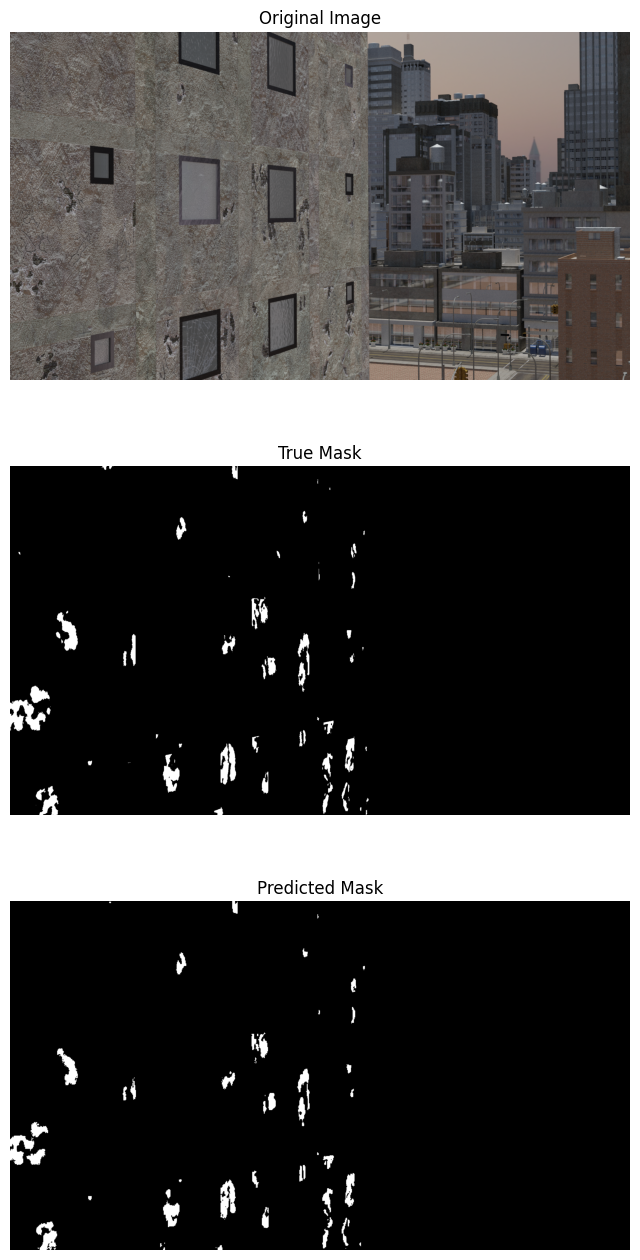

In [48]:
plt.figure(figsize=(8, 16))

plt.subplot(3, 1, 1)
plt.title("Original Image")
plt.imshow(test_image)
plt.axis("off")

plt.subplot(3, 1, 2)
plt.title("True Mask")
plt.imshow(tf.squeeze(true_mask), cmap = "gray")
plt.axis("off")

plt.subplot(3, 1, 3)
plt.title("Predicted Mask")
plt.imshow(tf.squeeze(pred_mask), cmap = "gray")
plt.axis("off")

In [52]:
logs = pd.read_csv(logs)

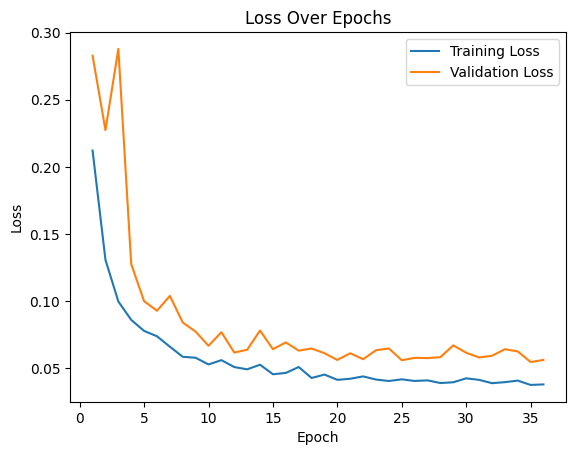

In [54]:
plt.plot(logs["epoch"]+1, logs["loss"], label = "Training Loss")
plt.plot(logs["epoch"]+1, logs["val_loss"], label = "Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

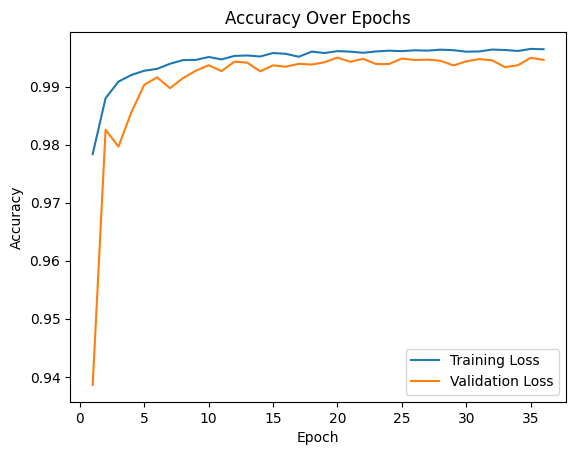

In [55]:
plt.plot(logs["epoch"]+1, logs["accuracy"], label = "Training Accuracy")
plt.plot(logs["epoch"]+1, logs["val_accuracy"], label = "Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

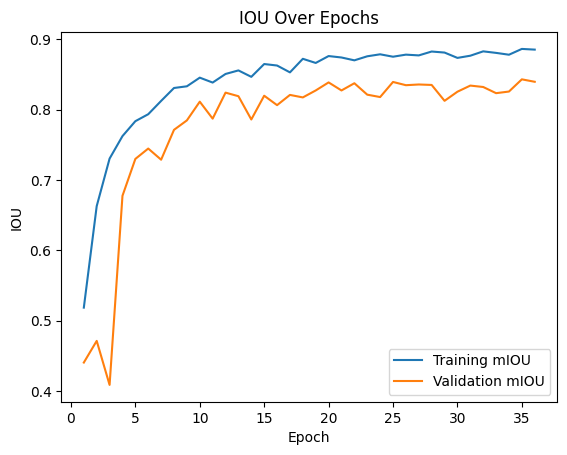

In [56]:
plt.plot(logs["epoch"]+1, logs["iou_metric"], label = "Training mIOU")
plt.plot(logs["epoch"]+1, logs["val_iou_metric"], label = "Validation mIOU")
plt.title("IOU Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IOU")
plt.legend()
plt.show()